<a href="https://colab.research.google.com/github/zilioalberto/Classificador_KNN/blob/main/Classificador_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificador utilizando algoritimo KNN
# Engenharia de Software
# Professor: Claudinei
# Alunos:
# Alberto Zilio
# Roni Pereira


In [12]:
# Bibliotecas
import pandas as pd
import numpy as np
import sklearn
import os, requests, io, sys, json, math, unicodedata,re
from urllib.parse import quote
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns



In [13]:
# Importação do algoritimo do github
# Data Set escolhido:  https://archive.ics.uci.edu/dataset/10/automobile

# ===== Config =====
OWNER  = "zilioalberto"
REPO   = "Classificador_KNN"
FOLDER = "automobile"     # pasta que contém os 4 arquivos
BRANCH = "main"


api_url = f"https://api.github.com/repos/{OWNER}/{REPO}/contents/{quote(FOLDER)}?ref={BRANCH}"


headers = {}

r = requests.get(api_url, headers=headers, timeout=30)
r.raise_for_status()
items = r.json()

files = [it for it in items if it.get("type") == "file"]
os.makedirs(f"/content/data/{FOLDER}", exist_ok=True)

print(f"Arquivos encontrados em {FOLDER}:")
for it in files:
    print(" -", it["name"])

for it in files:
    url = it["download_url"]
    name = it["name"]
    dest = f"/content/data/{FOLDER}/{name}"
    resp = requests.get(url, headers=headers, timeout=60)
    resp.raise_for_status()
    with open(dest, "wb") as f:
        f.write(resp.content)
    print(f"✔ Baixado: {dest}")

print("\nPronto. Pasta local:", f"/content/data/{FOLDER}")




Arquivos encontrados em automobile:
 - Index
 - imports-85.data
 - imports-85.names
 - misc
✔ Baixado: /content/data/automobile/Index
✔ Baixado: /content/data/automobile/imports-85.data
✔ Baixado: /content/data/automobile/imports-85.names
✔ Baixado: /content/data/automobile/misc

Pronto. Pasta local: /content/data/automobile


In [14]:
# Verificação dos arquivos importados

import os, io, sys, json, math
import pandas as pd
from pathlib import Path
from collections import Counter

# ---------- Config ----------
BASE_DIR = "/content/data/automobile"
MAX_PREVIEW_ROWS = 5                    # linhas para head/tail nas pré-visualizações

# ---------- Helpers ----------
COMMON_ENCODINGS = ("utf-8", "latin-1", "utf-16", "cp1252")
COMMON_SEPARATORS = [",", ";", "\t", "|"]

def detect_encoding(raw: bytes, candidates=COMMON_ENCODINGS):
    for enc in candidates:
        try:
            raw.decode(enc)
            return enc
        except UnicodeDecodeError:
            continue
    # fallback permissivo
    return "latin-1"

def sniff_separator(text: str, seps=COMMON_SEPARATORS, sample_lines=50):
    lines = [ln for ln in text.splitlines()[:sample_lines] if ln.strip()]
    if not lines:
        return None
    scores = {}
    for s in seps:
        # conta quantas colunas aparentes cada linha teria com esse separador
        cols = [len([c for c in ln.split(s)]) for ln in lines]
        # queremos consistência (baixa variância) e #cols > 1
        if max(cols) <= 1:
            continue
        var = pd.Series(cols).var(ddof=0)
        scores[s] = (var, -max(cols))  # menor var e mais colunas é melhor
    if not scores:
        # tenta whitespace
        try:
            df_try = pd.read_csv(io.StringIO(text), sep=r"\s+", engine="python")
            return r"\s+" if df_try.shape[1] > 1 else None
        except Exception:
            return None
    # escolhe por melhor (var mínima, mais colunas)
    return sorted(scores.items(), key=lambda kv: (kv[1][0], kv[1][1]))[0][0]

def try_load_dataframe(raw: bytes):
    enc = detect_encoding(raw)
    txt = raw.decode(enc, errors="ignore")
    sep = sniff_separator(txt)
    if not sep:
        # tenta CSV default como último recurso
        try:
            df = pd.read_csv(io.StringIO(txt))
            if df.shape[1] > 1:
                return df, enc, ","
        except Exception:
            return None, enc, None
        return None, enc, None
    try:
        df = pd.read_csv(io.StringIO(txt), sep=sep, engine="python")
        if df.shape[1] <= 1:
            return None, enc, sep
        return df, enc, sep
    except Exception:
        return None, enc, sep

def basic_df_report(df: pd.DataFrame, name: str):
    rep = {}
    rep["filename"] = name
    rep["rows"] = int(df.shape[0])
    rep["cols"] = int(df.shape[1])
    rep["columns"] = list(map(str, df.columns))
    rep["dtypes"] = {c: str(t) for c, t in df.dtypes.to_dict().items()}
    rep["null_counts"] = {c: int(df[c].isna().sum()) for c in df.columns}
    rep["duplicate_rows"] = int(df.duplicated().sum())
    # cardinalidade básica (limitada p/ custo)
    rep["unique_counts"] = {c: int(min(df[c].nunique(dropna=True), 999999)) for c in df.columns}
    # amostras
    rep["head"] = df.head(MAX_PREVIEW_ROWS).to_dict(orient="list")
    rep["tail"] = df.tail(MAX_PREVIEW_ROWS).to_dict(orient="list")
    # estatísticas numéricas simples
    try:
        rep["describe_numeric"] = df.describe(include="number").to_dict()
    except Exception:
        rep["describe_numeric"] = {}
    return rep

def audit_path(base_dir: str):
    base = Path(base_dir)
    assert base.exists(), f"Pasta não encontrada: {base_dir}"
    file_reports = []
    table_summaries = []
    dfs_loaded = {}  # nome -> df

    for p in sorted(base.iterdir()):
        if p.is_dir():
            continue
        name = p.name
        size = p.stat().st_size
        ext = p.suffix.lower()
        info = {
            "filename": name,
            "path": str(p),
            "ext": ext.replace(".", ""),
            "size_bytes": int(size),
            "is_tabular": False,
            "encoding": None,
            "separator": None,
            "load_error": None,
            "rows": None,
            "cols": None,
        }
        try:
            raw = p.read_bytes()
        except Exception as e:
            info["load_error"] = f"Erro leitura: {e}"
            file_reports.append(info)
            continue

        df, enc, sep = try_load_dataframe(raw)
        info["encoding"] = enc
        info["separator"] = sep

        if df is not None:
            info["is_tabular"] = True
            info["rows"], info["cols"] = int(df.shape[0]), int(df.shape[1])
            dfs_loaded[name] = df
            table_summaries.append({
                "arquivo": name,
                "linhas": int(df.shape[0]),
                "colunas": int(df.shape[1]),
                "sep": sep,
                "encoding": enc,
            })
        else:
            info["is_tabular"] = False

        file_reports.append(info)

    # detalha cada DF
    df_details = []
    for fname, df in dfs_loaded.items():
        df_details.append(basic_df_report(df, fname))

    # dataframes de resumo para visualização no Colab
    df_files = pd.DataFrame(file_reports).sort_values("filename").reset_index(drop=True)
    df_tables = pd.DataFrame(table_summaries).sort_values("arquivo").reset_index(drop=True)

    return df_files, df_tables, df_details, dfs_loaded


In [15]:
# Visualização dos resumos dos arquivos

df_files, df_tables, df_details, dfs_loaded = audit_path(BASE_DIR)

print("=== RESUMO DOS ARQUIVOS ENCONTRADOS ===")
display(df_files)

print("\n=== APENAS OS ARQUIVOS TABULARES CARREGADOS ===")
display(df_tables if not df_tables.empty else pd.DataFrame({"info":["Nenhum arquivo tabular detectado"]}))

# Mostra um resumo amigável por tabela
for rep in df_details:
    print("\n" + "="*90)
    print(f"ARQUIVO: {rep['filename']} | {rep['rows']} linhas x {rep['cols']} colunas")
    print("- Colunas:", ", ".join(rep["columns"]))
    print("- Tipos: ", {k:v for k,v in rep["dtypes"].items()})
    print("- Nulos: ", {k:v for k,v in rep["null_counts"].items() if v>0} or "sem nulos")
    print("- Duplicadas:", rep["duplicate_rows"])
    # head
    print("\nHEAD:")
    display(pd.DataFrame(rep["head"]))
    # tail
    print("TAIL:")
    display(pd.DataFrame(rep["tail"]))
    # describe numérico
    if rep["describe_numeric"]:
        print("DESCRIBE (numérico):")
        display(pd.DataFrame(rep["describe_numeric"]))


=== RESUMO DOS ARQUIVOS ENCONTRADOS ===


,filename,path,ext,size_bytes,is_tabular,encoding,separator,load_error,rows,cols
0,Index,/content/data/automobile/Index,,144,True,utf-8,\s+,None,4.0,3.0
1,automobile_clean.csv,/content/data/automobile/automobile_clean.csv,csv,27768,True,utf-8,",",None,205.0,27.0
2,imports-85.data,/content/data/automobile/imports-85.data,data,25936,True,utf-8,",",None,204.0,26.0
3,imports-85.names,/content/data/automobile/imports-85.names,names,4747,False,utf-8,\t,None,NaN,NaN
4,misc,/content/data/automobile/misc,,3757,False,utf-8,\t,None,NaN,NaN



=== APENAS OS ARQUIVOS TABULARES CARREGADOS ===


,arquivo,linhas,colunas,sep,encoding
0,Index,4,3,\s+,utf-8
1,automobile_clean.csv,205,27,",",utf-8
2,imports-85.data,204,26,",",utf-8



ARQUIVO: Index | 4 linhas x 3 colunas
- Colunas: Index, of, autos
- Tipos:  {'Index': 'int64', 'of': 'int64', 'autos': 'object'}
- Nulos:  sem nulos
- Duplicadas: 0

HEAD:


,Index,of,autos
0,1996,144,Index
1,1991,4747,imports-85.names
2,1990,3757,misc
3,1989,25936,imports-85.data


TAIL:


,Index,of,autos
0,1996,144,Index
1,1991,4747,imports-85.names
2,1990,3757,misc
3,1989,25936,imports-85.data


DESCRIBE (numérico):


,Index,of
count,4.000000,4.000000
mean,1991.500000,8646.000000
std,3.109126,11695.193115
min,1989.000000,144.000000
25%,1989.750000,2853.750000
50%,1990.500000,4252.000000
75%,1992.250000,10044.250000
max,1996.000000,25936.000000



ARQUIVO: automobile_clean.csv | 205 linhas x 27 colunas
- Colunas: symboling, normalized_losses, make, fuel_type, aspiration, num_of_doors, body_style, drive_wheels, engine_location, wheel_base, length, width, height, curb_weight, engine_type, num_of_cylinders, engine_size, fuel_system, bore, stroke, compression_ratio, horsepower, peak_rpm, city_mpg, highway_mpg, price, num_of_cylinders_num
- Tipos:  {'symboling': 'int64', 'normalized_losses': 'float64', 'make': 'object', 'fuel_type': 'object', 'aspiration': 'object', 'num_of_doors': 'object', 'body_style': 'object', 'drive_wheels': 'object', 'engine_location': 'object', 'wheel_base': 'float64', 'length': 'float64', 'width': 'float64', 'height': 'float64', 'curb_weight': 'int64', 'engine_type': 'object', 'num_of_cylinders': 'object', 'engine_size': 'int64', 'fuel_system': 'object', 'bore': 'float64', 'stroke': 'float64', 'compression_ratio': 'float64', 'horsepower': 'float64', 'peak_rpm': 'float64', 'city_mpg': 'int64', 'highway_mpg':

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,num_of_cylinders_num
0,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,4.0
1,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,4.0
2,1,115.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,6.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,4.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,5.0


TAIL:


,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,num_of_cylinders_num
0,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0,4.0
1,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0,4.0
2,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0,6.0
3,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0,6.0
4,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,9.5,114.0,5400.0,19,25,22625.0,4.0


DESCRIBE (numérico):


,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,num_of_cylinders_num
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,120.600000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329366,3.256098,10.142537,104.165854,5126.097561,25.219512,30.751220,13150.307317,4.380488
std,1.245307,31.805105,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270858,0.313634,3.972040,39.529733,477.035772,6.542142,6.886443,7879.121326,1.080854
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,2.000000
25%,0.000000,101.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000,4.000000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000,4.000000
75%,2.000000,137.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000,4.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000,12.000000



ARQUIVO: imports-85.data | 204 linhas x 26 colunas
- Colunas: 3, ?, alfa-romero, gas, std, two, convertible, rwd, front, 88.60, 168.80, 64.10, 48.80, 2548, dohc, four, 130, mpfi, 3.47, 2.68, 9.00, 111, 5000, 21, 27, 13495
- Tipos:  {'3': 'int64', '?': 'object', 'alfa-romero': 'object', 'gas': 'object', 'std': 'object', 'two': 'object', 'convertible': 'object', 'rwd': 'object', 'front': 'object', '88.60': 'float64', '168.80': 'float64', '64.10': 'float64', '48.80': 'float64', '2548': 'int64', 'dohc': 'object', 'four': 'object', '130': 'int64', 'mpfi': 'object', '3.47': 'object', '2.68': 'object', '9.00': 'float64', '111': 'object', '5000': 'object', '21': 'int64', '27': 'int64', '13495': 'object'}
- Nulos:  sem nulos
- Duplicadas: 0

HEAD:


,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


TAIL:


,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
1,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
2,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
3,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470
4,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,19,25,22625


DESCRIBE (numérico):


,3,88.60,168.80,64.10,48.80,2548,130,9.00,21,27
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,0.823529,98.806373,174.075000,65.916667,53.749020,2555.602941,126.892157,10.148137,25.240196,30.769608
std,1.239035,5.994144,12.362123,2.146716,2.424901,521.960820,41.744569,3.981000,6.551513,6.898337
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.075000,52.000000,2145.000000,97.000000,8.575000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,119.500000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.200000,66.900000,55.500000,2939.250000,142.000000,9.400000,30.000000,34.500000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [16]:
# Tratamento do dataset
# Leitura + padronização de colunas + tratamento de nulos + remoção de duplicatas

# --------- CONFIG ---------

DATA_DIR = "/content/data/automobile"

FILE_DATA  = "imports-85.data"
FILE_NAMES = "imports-85.names"

# Percentual mínimo de dados não-nulos para manter a coluna
MIN_NON_NULL_RATIO = 0.60

# Salvar CSV limpo junto ao arquivo original
SAVE_CLEAN_CSV = True
CLEAN_CSV_NAME = "automobile_clean.csv"
# --------------------------

# Verificações de existência
data_path  = Path(DATA_DIR) / FILE_DATA
names_path = Path(DATA_DIR) / FILE_NAMES

if not data_path.exists():
    raise FileNotFoundError(
        f"Não encontrei '{FILE_DATA}' em {DATA_DIR}.\n"
        f"Ajuste DATA_DIR ou mova o arquivo para lá."
    )

print(f"Usando arquivo: {data_path}")

# Esquema (26 colunas) do imports-85
RAW_COLUMNS = [
    "symboling","normalized-losses","make","fuel-type","aspiration","num-of-doors",
    "body-style","drive-wheels","engine-location","wheel-base","length","width",
    "height","curb-weight","engine-type","num-of-cylinders","engine-size",
    "fuel-system","bore","stroke","compression-ratio","horsepower","peak-rpm",
    "city-mpg","highway-mpg","price",
]

def to_snake(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.strip()
    s = s.replace("/", " ").replace("-", " ")
    s = re.sub(r"[^\w\s]", "_", s, flags=re.UNICODE)
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("_").lower()

def coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

# 1) Leitura local: "?" -> NaN
df = pd.read_csv(data_path, header=None, names=RAW_COLUMNS, na_values="?")

# 2) Padronizar nomes (snake_case)
df.columns = [to_snake(c) for c in df.columns]

# 3) Conversões específicas
#    a) num_of_cylinders (texto -> número)
cyl_map = {"two":2,"three":3,"four":4,"five":5,"six":6,"seven":7,"eight":8,"twelve":12}
if "num_of_cylinders" in df.columns:
    df["num_of_cylinders_num"] = df["num_of_cylinders"].map(cyl_map).astype("float")

#    b) colunas conhecidas como numéricas
numeric_cols = [
    "symboling","normalized_losses","wheel_base","length","width","height",
    "curb_weight","engine_size","bore","stroke","compression_ratio",
    "horsepower","peak_rpm","city_mpg","highway_mpg","price","num_of_cylinders_num"
]
df = coerce_numeric(df, [c for c in numeric_cols if c in df.columns])

# 4) Remover colunas muito esparsas
non_null_ratio = df.notna().mean()
keep_cols = non_null_ratio[non_null_ratio >= MIN_NON_NULL_RATIO].index.tolist()
dropped_sparse = [c for c in df.columns if c not in keep_cols]
df = df[keep_cols]

# 5) Remover duplicatas
before = df.shape[0]
df = df.drop_duplicates()
removed_dups = before - df.shape[0]

# 6) Imputação simples (mediana p/ numéricos; moda p/ categóricos)
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

for c in num_cols:
    med = df[c].median() if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med)

for c in cat_cols:
    if df[c].notna().any():
        mode = df[c].mode(dropna=True)
        val = mode.iloc[0] if not mode.empty else ""
    else:
        val = ""
    df[c] = df[c].fillna(val)

# 7) Relatórios rápidos
print("=== RESUMO APÓS LIMPEZA ===")
print(f"Linhas: {df.shape[0]} | Colunas: {df.shape[1]}")
print("Colunas removidas por excesso de nulos:", dropped_sparse or "nenhuma")
print("Linhas duplicadas removidas:", removed_dups)
print("\nTipos inferidos:")
print(df.dtypes)

print("\nNulos por coluna (após imputação):")
print(df.isna().sum())

print("\nPrévia:")
display(df.head(10))

# 8) Salvar CSV limpo ao lado do arquivo original
if SAVE_CLEAN_CSV:
    out_path = data_path.parent / CLEAN_CSV_NAME
    df.to_csv(out_path, index=False)
    print(f"\n✔ CSV limpo salvo em: {out_path}")



Usando arquivo: /content/data/automobile/imports-85.data
=== RESUMO APÓS LIMPEZA ===
Linhas: 205 | Colunas: 27
Colunas removidas por excesso de nulos: nenhuma
Linhas duplicadas removidas: 0

Tipos inferidos:
symboling                 int64
normalized_losses       float64
make                     object
fuel_type                object
aspiration               object
num_of_doors             object
body_style               object
drive_wheels             object
engine_location          object
wheel_base              float64
length                  float64
width                   float64
height                  float64
curb_weight               int64
engine_type              object
num_of_cylinders         object
engine_size               int64
fuel_system              object
bore                    float64
stroke                  float64
compression_ratio       float64
horsepower              float64
peak_rpm                float64
city_mpg                  int64
highway_mpg             

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,num_of_cylinders_num
0,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,4.0
1,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,4.0
2,1,115.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,6.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,4.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,5.0
5,2,115.0,audi,gas,std,two,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0,5.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0,5.0
7,1,115.0,audi,gas,std,four,wagon,fwd,front,105.8,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0,5.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0,5.0
9,0,115.0,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,10295.0,5.0



✔ CSV limpo salvo em: /content/data/automobile/automobile_clean.csv



=== CONFIGURAÇÃO ===
Alvo: price
Nº de features: 26  (Numéricas: 16 | Categóricas: 10)
Divisão treino/teste: 70/30%
Tamanho treino: 143 | Tamanho teste: 62
→ Alvo numérico: KNeighborsRegressor

=== RESULTADOS (Regressão) ===
RMSE (erro médio quadrático raiz): 4,549.65
R² (coeficiente de determinação): 0.699


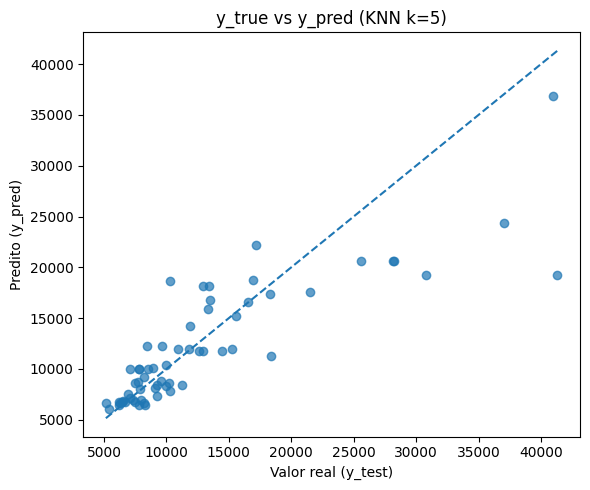

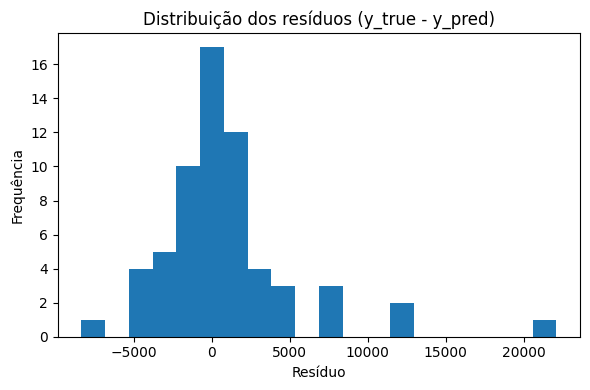

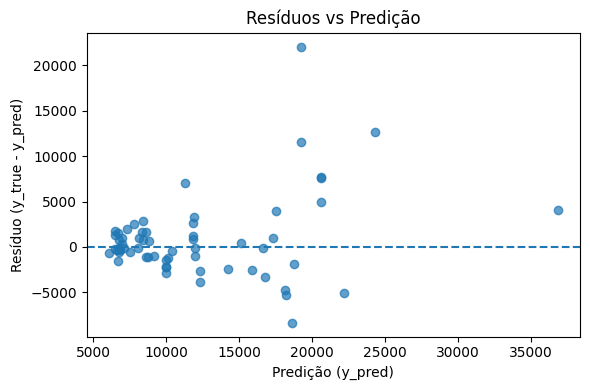

In [17]:
# KNN — escalonamento + codificação + treino/avaliação

# ---------------- CONFIG ----------------
CSV_PATH   = "/content/data/automobile/automobile_clean.csv"
TARGET_COL = "price"        # 'price' = regressão; troque p/ col categórica p/ classificação
TEST_SIZE  = 0.30           # 30% avaliação (70% treino)
RANDOM_STATE = 42
N_NEIGHBORS  = 5
# -----------------------------------------

# 1) Ler CSV limpo
df = pd.read_csv(CSV_PATH)

# 2) Separar X e y
if TARGET_COL not in df.columns:
    raise ValueError(f"Coluna '{TARGET_COL}' não encontrada no CSV.")
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# 3) Identificar colunas numéricas/categóricas
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"\n=== CONFIGURAÇÃO ===")
print(f"Alvo: {TARGET_COL}")
print(f"Nº de features: {len(X.columns)}  (Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)})")
print(f"Divisão treino/teste: {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}%")

# 4) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"Tamanho treino: {X_train.shape[0]} | Tamanho teste: {X_test.shape[0]}")

# 5) Pré-processamento
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ],
    remainder='drop'
)

# 6) Escolher modelo
if np.issubdtype(y_train.dtype, np.number):
    print("→ Alvo numérico: KNeighborsRegressor")
    estimator = KNeighborsRegressor(n_neighbors=N_NEIGHBORS)
    task = "reg"
else:
    print("→ Alvo categórico: KNeighborsClassifier")
    estimator = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
    task = "clf"

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', estimator),
])

# 7) Treinar
pipe.fit(X_train, y_train)

# 8) Avaliar
y_pred = pipe.predict(X_test)

if task == "reg":
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    print("\n=== RESULTADOS (Regressão) ===")
    print(f"RMSE (erro médio quadrático raiz): {rmse:,.2f}")
    print(f"R² (coeficiente de determinação): {r2:.3f}")

    # ---- Gráficos úteis para regressão ----
    # 1) y_true vs y_pred
    plt.figure(figsize=(6,5))
    plt.scatter(y_test, y_pred, alpha=0.7)
    # linha de referência y=x
    min_v = min(y_test.min(), y_pred.min())
    max_v = max(y_test.max(), y_pred.max())
    plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
    plt.title(f"y_true vs y_pred (KNN k={N_NEIGHBORS})")
    plt.xlabel("Valor real (y_test)")
    plt.ylabel("Predito (y_pred)")
    plt.tight_layout()
    plt.show()

    # 2) Histograma dos resíduos
    residuals = y_test - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=20)
    plt.title("Distribuição dos resíduos (y_true - y_pred)")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()

    # 3) Resíduos vs predição
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, linestyle="--")
    plt.title("Resíduos vs Predição")
    plt.xlabel("Predição (y_pred)")
    plt.ylabel("Resíduo (y_true - y_pred)")
    plt.tight_layout()
    plt.show()

else:
    acc = accuracy_score(y_test, y_pred)
    print("\n=== RESULTADOS (Classificação) ===")
    print(f"Acurácia no teste: {acc:.2%}")

    print("\nRelatório detalhado:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusão (absoluta)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão (KNN k={N_NEIGHBORS})')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.tight_layout()
    plt.show()


=== RESULTADOS GRID — Alvo original ===
Melhores parâmetros (refit por R²):
{'model__algorithm': 'auto', 'model__leaf_size': 20, 'model__metric': 'minkowski', 'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance', 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['symboling', 'normalized_losses',
                                  'wheel_base', 'length', 'width', 'height',
                                  'curb_weight', 'engine_size', 'bore',
                                  'stroke', 'compression_ratio', 'horsepower',
                                  'peak_rpm', 'city_mpg', 'highway_mpg',
                                  'num_of_cylinders_num']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
           

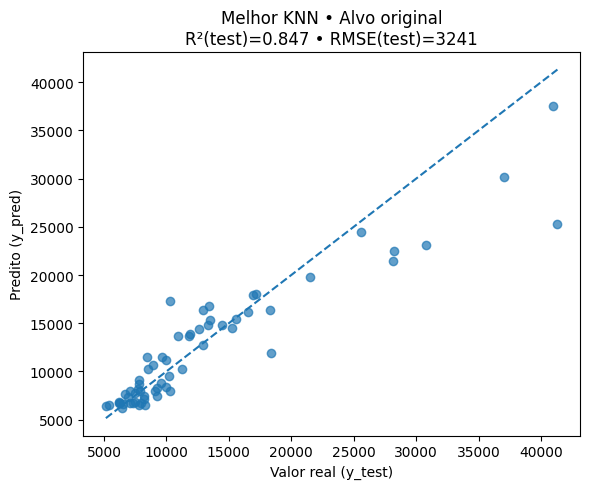

In [18]:
# KNN Regressão — GridSearchCV + Seleção do melhor + Gráfico do melhor resultado
# - Scalers: StandardScaler vs RobustScaler
# - Hiperparâmetros: k, weights, p (Manhattan/Euclidiana)
# - Compara alvo original vs log1p (TTR)
# - Mostra melhores parâmetros, métricas de CV e teste, e plota y_true vs y_pred


# ---------------- CONFIG ----------------
CSV_PATH     = "/content/data/automobile/automobile_clean.csv"  # ajuste se necessário
TARGET_COL   = "price"
TEST_SIZE    = 0.30
RANDOM_STATE = 42

# grade de vizinhos (ajuste conforme tempo)
K_LIST = [3,5,7,9,11,15,21]

# testar também log-transform do alvo
TRY_LOG_TARGET = True
# -----------------------------------------

# 1) Ler
df = pd.read_csv(CSV_PATH)
assert TARGET_COL in df.columns, f"TARGET_COL '{TARGET_COL}' não encontrada"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(float)

# 2) Split 70/30 fixo para comparação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# 3) Tipos de features
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# 4) Pré-processadores de numéricas (alternaremos no grid)
numeric_std = Pipeline([("scaler", StandardScaler())])
numeric_rob = Pipeline([("scaler", RobustScaler())])
categoricals = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

pre_std = ColumnTransformer(
    transformers=[
        ("num", numeric_std, num_cols),
        ("cat", categoricals, cat_cols),
    ],
    remainder="drop"
)
pre_rob = ColumnTransformer(
    transformers=[
        ("num", numeric_rob, num_cols),
        ("cat", categoricals, cat_cols),
    ],
    remainder="drop"
)

# 5) Pipeline base
base_reg = KNeighborsRegressor()
pipe = Pipeline([
    ("preprocessor", pre_std),   # placeholder; será trocado via grid
    ("model", base_reg),
])

# 6) Scorers nativos (refit por R²; também medimos RMSE com 'neg_root_mean_squared_error')
SCORING = {"r2": "r2", "neg_rmse": "neg_root_mean_squared_error"}
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 7) Grade de parâmetros (simplificada para evitar warnings estranhos)
param_grid = [{
    "preprocessor": [pre_std, pre_rob],
    "model__n_neighbors": K_LIST,
    "model__weights": ["uniform", "distance"],
    "model__metric": ["minkowski"],
    "model__p": [1, 2],                 # 1=Manhattan, 2=Euclidiana
    "model__algorithm": ["auto"],       # manter "auto" para estabilidade
    "model__leaf_size": [20, 30, 40],
}]

def run_search(pipeline, grid, X, y, label):
    search = GridSearchCV(
        estimator=pipeline,
        param_grid=grid,
        cv=cv,
        scoring=SCORING,
        refit="r2",
        n_jobs=-1,
        verbose=0,
        error_score="raise"
    )
    search.fit(X, y)
    # métricas de CV
    best_r2_cv = search.best_score_
    best_rmse_cv = -search.cv_results_["mean_test_neg_rmse"][search.best_index_]
    print(f"\n=== RESULTADOS GRID — {label} ===")
    print("Melhores parâmetros (refit por R²):")
    print(search.best_params_)
    print(f"Melhor R² (CV):  {best_r2_cv:.3f}")
    print(f"Melhor RMSE (CV): {best_rmse_cv:.2f}")
    return search, best_r2_cv, best_rmse_cv

# 8a) Alvo original
search_plain, r2_cv_plain, rmse_cv_plain = run_search(pipe, param_grid, X_train, y_train, "Alvo original")

# 8b) Alvo com log1p (se habilitado)
search_log = None
r2_cv_log = -np.inf
rmse_cv_log = np.inf
if TRY_LOG_TARGET:
    pipe_ttr = TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    )
    param_grid_ttr = [{
        "regressor__preprocessor": [pre_std, pre_rob],
        "regressor__model__n_neighbors": K_LIST,
        "regressor__model__weights": ["uniform", "distance"],
        "regressor__model__metric": ["minkowski"],
        "regressor__model__p": [1, 2],
        "regressor__model__algorithm": ["auto"],
        "regressor__model__leaf_size": [20, 30, 40],
    }]
    search_log = GridSearchCV(
        estimator=pipe_ttr,
        param_grid=param_grid_ttr,
        cv=cv,
        scoring=SCORING,
        refit="r2",
        n_jobs=-1,
        verbose=0,
        error_score="raise"
    )
    search_log.fit(X_train, y_train)

    # Em alguns ambientes, 'cv_results_["mean_test_neg_rmse"]' no TTR pode dar NaN.
    # Por segurança, calculamos RMSE(CV) do melhor estimator com cross_val_score:
    r2_cv_log = search_log.best_score_
    rmse_cv_log_scores = -cross_val_score(
        search_log.best_estimator_, X_train, y_train,
        cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    )
    rmse_cv_log = rmse_cv_log_scores.mean()

    print("\n=== RESULTADOS GRID — Alvo com log1p ===")
    print("Melhores parâmetros (refit por R²):")
    print(search_log.best_params_)
    print(f"Melhor R² (CV):  {r2_cv_log:.3f}")
    print(f"RMSE (CV) via cross_val_score: {rmse_cv_log:.2f}  ± {rmse_cv_log_scores.std():.2f}")

# 9) Seleção do vencedor (critério: maior R²(CV))
best_estimator = search_plain.best_estimator_
best_label     = "Alvo original"
best_params    = search_plain.best_params_
best_r2_cv     = r2_cv_plain
best_rmse_cv   = rmse_cv_plain

if search_log is not None and r2_cv_log > best_r2_cv:
    best_estimator = search_log.best_estimator_
    best_label     = "Alvo com log1p"
    best_params    = search_log.best_params_
    best_r2_cv     = r2_cv_log
    best_rmse_cv   = rmse_cv_log

print("\n>>> SELECIONADO PARA TESTE")
print(f"Variação: {best_label}")
print("Parâmetros do melhor modelo:")
print(best_params)
print(f"R² (CV):  {best_r2_cv:.3f}")
print(f"RMSE (CV): {best_rmse_cv:.2f}")

# 10) Avaliação final no TESTE e GRÁFICO do melhor resultado
y_pred = best_estimator.predict(X_test)
rmse_test = np.sqrt(np.mean((y_test - y_pred)**2))
r2_test   = r2_score(y_test, y_pred)

print("\n=== AVALIAÇÃO NO TESTE (70/30) — MELHOR MODELO ===")
print(f"R² (teste):   {r2_test:.3f}")
print(f"RMSE (teste): {rmse_test:.2f}")

# Gráfico: y_true vs y_pred do melhor
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.7)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.title(f"Melhor KNN • {best_label}\nR²(test)={r2_test:.3f} • RMSE(test)={rmse_test:.0f}")
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predito (y_pred)")
plt.tight_layout()
plt.show()
